In [1]:
import pandas as pd  # Data manipulation
import numpy as np  # Numerical operations
import matplotlib.pyplot as plt  # Plots
import seaborn as sns  # Data visualization
from scipy import stats  # Statistical functions and tests
import statsmodels.regression.linear_model as sm  # Linear regression models
from statsmodels.tsa.stattools import adfuller, kpss # Functions for stationarity tests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  # Autocorrelation graphs
from statsmodels.tsa.arima.model import ARIMA  # ARIMA model for fitting residuals
from statsmodels.stats.diagnostic import acorr_ljungbox  # Ljung-Box test for autocorrelation
from statsmodels.tsa.seasonal import seasonal_decompose  # Time series decomposition
from IPython.display import display  # Function to display images in the notebook
from sklearn.metrics import mean_squared_error  # Function to calculate mean squared error
import plotly.express as px  # Interactive plotting library
import plotly.graph_objects as go  # Low-level interface for plotly


import warnings

# Settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')  
sns.set_theme(style="whitegrid")
pd.set_option('display.max_columns', None)
%matplotlib inline

# **Short-term Forecasting for Housing Prices**


In this project I will calibrate a short-term prediction model and evaluate its performance by mean-squared errors. The data used for this analysis is from Zillow Group, and we will focus on the Boston housing market.

We assume an additive form of prediction model:

$$
\hat{X}_t = \hat{y}_t + AR_t, \quad \forall t
$$

where: $ \hat{X}_t $ is the estimated housing prices of Boston, $\hat{y}_t$ is the non-stationary component captured by a Hankel-based unstructured model, and $AR_t$ is the stationary component captured by an autoregressive model.

We calibrate this model in two steps:
1. Fit the Hankel-based unstructured model.
2. Calculate the residual series and fit the autoregressive model to match the residuals.

# **Exploratory Data Analysis** 

## **Analysis Structure**

1. **Initial Analysis and Data Preparation**
   - Loading and structure verification
   - Analysis of data types, missing values, and duplicates
   - Basic descriptive statistical analysis and outlier identification

2. **Advanced Statistical Visualizations and Analysis**
   - Detailed visualizations (histograms, boxplots, scatter plots, and heatmaps)
   - Normality and distribution tests
   - Correlation analysis and identification of relevant pattern
   - Deep Temporal Analysis

## **1. Initial Analysis and Data Preparation**


In [2]:
# Loading the data
df = pd.read_csv('data_zillow_house_prices.csv')

# Basic information about the dataset
print("=== Basic Dataset Information ===\n")
print(f"Dataset dimensions: {df.shape}")
print(f"\nDataset columns:")
print(df.columns.tolist())
print("\nFirst rows of the dataset:")
display(df.head())
print("\nDetailed information:")
df.info()

=== Basic Dataset Information ===

Dataset dimensions: (893, 277)

Dataset columns:
['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName', '2000-01-31', '2000-02-29', '2000-03-31', '2000-04-30', '2000-05-31', '2000-06-30', '2000-07-31', '2000-08-31', '2000-09-30', '2000-10-31', '2000-11-30', '2000-12-31', '2001-01-31', '2001-02-28', '2001-03-31', '2001-04-30', '2001-05-31', '2001-06-30', '2001-07-31', '2001-08-31', '2001-09-30', '2001-10-31', '2001-11-30', '2001-12-31', '2002-01-31', '2002-02-28', '2002-03-31', '2002-04-30', '2002-05-31', '2002-06-30', '2002-07-31', '2002-08-31', '2002-09-30', '2002-10-31', '2002-11-30', '2002-12-31', '2003-01-31', '2003-02-28', '2003-03-31', '2003-04-30', '2003-05-31', '2003-06-30', '2003-07-31', '2003-08-31', '2003-09-30', '2003-10-31', '2003-11-30', '2003-12-31', '2004-01-31', '2004-02-29', '2004-03-31', '2004-04-30', '2004-05-31', '2004-06-30', '2004-07-31', '2004-08-31', '2004-09-30', '2004-10-31', '2004-11-30', '2004-12-31', '2005-01-3

,RegionID,SizeRank,RegionName,RegionType,StateName,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,2000-09-30,2000-10-31,2000-11-30,2000-12-31,2001-01-31,2001-02-28,2001-03-31,2001-04-30,2001-05-31,2001-06-30,2001-07-31,2001-08-31,2001-09-30,2001-10-31,2001-11-30,2001-12-31,2002-01-31,2002-02-28,2002-03-31,2002-04-30,2002-05-31,2002-06-30,2002-07-31,2002-08-31,2002-09-30,2002-10-31,2002-11-30,2002-12-31,2003-01-31,2003-02-28,2003-03-31,2003-04-30,2003-05-31,2003-06-30,2003-07-31,2003-08-31,2003-09-30,2003-10-31,2003-11-30,2003-12-31,2004-01-31,2004-02-29,2004-03-31,2004-04-30,2004-05-31,2004-06-30,2004-07-31,2004-08-31,2004-09-30,2004-10-31,2004-11-30,2004-12-31,2005-01-31,2005-02-28,2005-03-31,2005-04-30,2005-05-31,2005-06-30,2005-07-31,2005-08-31,2005-09-30,2005-10-31,2005-11-30,2005-12-31,2006-01-31,2006-02-28,2006-03-31,2006-04-30,2006-05-31,2006-06-30,2006-07-31,2006-08-31,2006-09-30,2006-10-31,2006-11-30,2006-12-31,2007-01-31,2007-02-28,2007-03-31,2007-04-30,2007-05-31,2007-06-30,2007-07-31,2007-08-31,2007-09-30,2007-10-31,2007-11-30,2007-12-31,2008-01-31,2008-02-29,2008-03-31,2008-04-30,2008-05-31,2008-06-30,2008-07-31,2008-08-31,2008-09-30,2008-10-31,2008-11-30,2008-12-31,2009-01-31,2009-02-28,2009-03-31,2009-04-30,2009-05-31,2009-06-30,2009-07-31,2009-08-31,2009-09-30,2009-10-31,2009-11-30,2009-12-31,2010-01-31,2010-02-28,2010-03-31,2010-04-30,2010-05-31,2010-06-30,2010-07-31,2010-08-31,2010-09-30,2010-10-31,2010-11-30,2010-12-31,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,2011-11-30,2011-12-31,2012-01-31,2012-02-29,2012-03-31,2012-04-30,2012-05-31,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,2013-03-31,2013-04-30,2013-05-31,2013-06-30,2013-07-31,2013-08-31,2013-09-30,2013-10-31,2013-11-30,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-31,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-10-31,2014-11-30,2014-12-31,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,2015-11-30,2015-12-31,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28,2021-03-31,2021-04-30,2021-05-31,2021-06-30,2021-07-31,2021-08-31,2021-09-30,2021-10-31,2021-11-30,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31
0,102001,0,United States,country,NaN,127881.0,128227.0,128591.0,129332.0,130079.0,130824.0,131584.0,132394.0,133222.0,134055.0,134895.0,135756.0,136559.0,137298.0,138048.0,138850.0,139676.0,140486.0,141302.0,142147.0,142983.0,143824.0,144594.0,145330.0,146001.0,146702.0,147441.0,148223.0,149056.0,149933.0,150884.0,151877.0,152859.0,153846.0,154777.0,155705.0,156551.0,157414.0,158299.0,159256.0,160280.0,161300.0,162365.0,163489.0,164679.0,165867.0,166940.0,167966.0,168987.0,170159.0,171468.0,172899.0,174481.0,176166.0,177959.0,179722.0,181441.0,183076.0,184605.0,186158.0,187684.0,189286.0,190949.0,192859.0,194848.0,196920.0,198968.0,201030.0,203023.0,204875.0,206531.0,208014.0,209269.0,210482.0,211750.0,213122.0,214432.0,215531.0,216336.0,216943.0,217282.0,217526.0,217603.0,217647.0,217629.0,217648.0,217656.0,217674.0,217515.0,217162.0,216550.0,215903.0,215115.0,214295.0,213262.0,212219.0,210974.0,209626.0,208117.0,206541.0,204951.0,203272.0,20


Detailed information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 893 entries, 0 to 892
Columns: 277 entries, RegionID to 2022-08-31
dtypes: float64(272), int64(2), object(3)
memory usage: 1.9+ MB


In [3]:
# Missing values analysis
missing_values = df.isnull().sum()
missing_pct = (missing_values / len(df)) * 100

print("=== Missing Values Analysis ===\n")
missing_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage (%)': missing_pct
})

# Showing only columns with missing values
missing_df_filtered = missing_df[missing_df['Missing Values'] > 0]
if not missing_df_filtered.empty:
    print("\nColumns with missing values:")
    display(missing_df_filtered)
else:
    print("\nNo missing values found in the dataset!")

# Checking for duplicates
duplicates = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")

=== Missing Values Analysis ===


Columns with missing values:


,Missing Values,Percentage (%)
StateName,1,0.111982
2000-01-31,457,51.175812
2000-02-29,456,51.063830
2000-03-31,455,50.951848
2000-04-30,453,50.727884
...,...,...
2021-11-30,2,0.223964
2021-12-31,7,0.783875
2022-01-31,3,0.335946
2022-02-28,3,0.335946



Number of duplicate rows: 0


In [4]:
# Descriptive statistical analysis and outlier identification
print("=== Descriptive Statistics ===\n")

# Separating numerical and categorical columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
categorical_cols = df.select_dtypes(exclude=[np.number]).columns

print("Statistics for numerical columns:")
display(df[numeric_cols].describe())

=== Descriptive Statistics ===

Statistics for numerical columns:


,RegionID,SizeRank,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,2000-09-30,2000-10-31,2000-11-30,2000-12-31,2001-01-31,2001-02-28,2001-03-31,2001-04-30,2001-05-31,2001-06-30,2001-07-31,2001-08-31,2001-09-30,2001-10-31,2001-11-30,2001-12-31,2002-01-31,2002-02-28,2002-03-31,2002-04-30,2002-05-31,2002-06-30,2002-07-31,2002-08-31,2002-09-30,2002-10-31,2002-11-30,2002-12-31,2003-01-31,2003-02-28,2003-03-31,2003-04-30,2003-05-31,2003-06-30,2003-07-31,2003-08-31,2003-09-30,2003-10-31,2003-11-30,2003-12-31,2004-01-31,2004-02-29,2004-03-31,2004-04-30,2004-05-31,2004-06-30,2004-07-31,2004-08-31,2004-09-30,2004-10-31,2004-11-30,2004-12-31,2005-01-31,2005-02-28,2005-03-31,2005-04-30,2005-05-31,2005-06-30,2005-07-31,2005-08-31,2005-09-30,2005-10-31,2005-11-30,2005-12-31,2006-01-31,2006-02-28,2006-03-31,2006-04-30,2006-05-31,2006-06-30,2006-07-31,2006-08-31,2006-09-30,2006-10-31,2006-11-30,2006-12-31,2007-01-31,2007-02-28,2007-03-31,2007-04-30,2007-05-31,2007-06-30,2007-07-31,2007-08-31,2007-09-30,2007-10-31,2007-11-30,2007-12-31,2008-01-31,2008-02-29,2008-03-31,2008-04-30,2008-05-31,2008-06-30,2008-07-31,2008-08-31,2008-09-30,2008-10-31,2008-11-30,2008-12-31,2009-01-31,2009-02-28,2009-03-31,2009-04-30,2009-05-31,2009-06-30,2009-07-31,2009-08-31,2009-09-30,2009-10-31,2009-11-30,2009-12-31,2010-01-31,2010-02-28,2010-03-31,2010-04-30,2010-05-31,2010-06-30,2010-07-31,2010-08-31,2010-09-30,2010-10-31,2010-11-30,2010-12-31,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,2011-11-30,2011-12-31,2012-01-31,2012-02-29,2012-03-31,2012-04-30,2012-05-31,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,2013-03-31,2013-04-30,2013-05-31,2013-06-30,2013-07-31,2013-08-31,2013-09-30,2013-10-31,2013-11-30,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-31,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-10-31,2014-11-30,2014-12-31,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,2015-11-30,2015-12-31,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28,2021-03-31,2021-04-30,2021-05-31,2021-06-30,2021-07-31,2021-08-31,2021-09-30,2021-10-31,2021-11-30,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31
count,893.000000,893.000000,436.000000,437.000000,438.000000,440.000000,442.000000,443.000000,444.000000,445.000000,446.000000,446.000000,449.000000,450.000000,458.000000,458.000000,458.000000,460.000000,461.000000,462.000000,463.000000,463.000000,463.000000,464.000000,465.000000,466.000000,467.000000,467.000000,467.000000,473.000000,475.000000,476.000000,477.000000,477.000000,475.000000,476.000000,474.000000,475.000000,478.000000,480.000000,482.000000,483.000000,485.000000,485.000000,488.000000,479.000000,483.000000,482.000000,489.000000,496.000000,498.000000,498.000000,497.000000,504.000000,501.000000,500.000000,502.000000,498.000000,503.000000,509.000000,511.000000,510.000000,496.000000,500.00000,508.000000,502.000000,518.000000,521.000000,522.000000,524.000000,523.000000,527.000000,529.000000,534.000000,536.00000,539.000000,539.000000,539.000000,539.000000,542.000000,543.000000,544.000000,547.000000,549.000000,548.000000,548.000000,552.000000,555.000000,555.000000,555.00

In [5]:
# Filtering data for Boston:
boston_df = df[df['RegionName'] == 'Boston, MA']  


# Transpose the dataframe to have dates as the index:
boston_prices = boston_df.iloc[:, 5:].transpose()
# Rename the column for easier access
boston_prices.columns = ['Prices']

boston_prices

,Prices
2000-01-31,231718.0
2000-02-29,233010.0
2000-03-31,234265.0
2000-04-30,236467.0
2000-05-31,238657.0
...,...
2022-04-30,643355.0
2022-05-31,651279.0
2022-06-30,656882.0
2022-07-31,658173.0


In [6]:
# Filtering data for train and test period:
boston_train = boston_prices['2010-01-31':'2017-12-31']
boston_test = boston_prices['2018-01-01':'2019-12-31']

## **2. Advanced Statistical Visualizations and Analysis**

In this section, we deepen the analysis through visualizations and statistical tests.

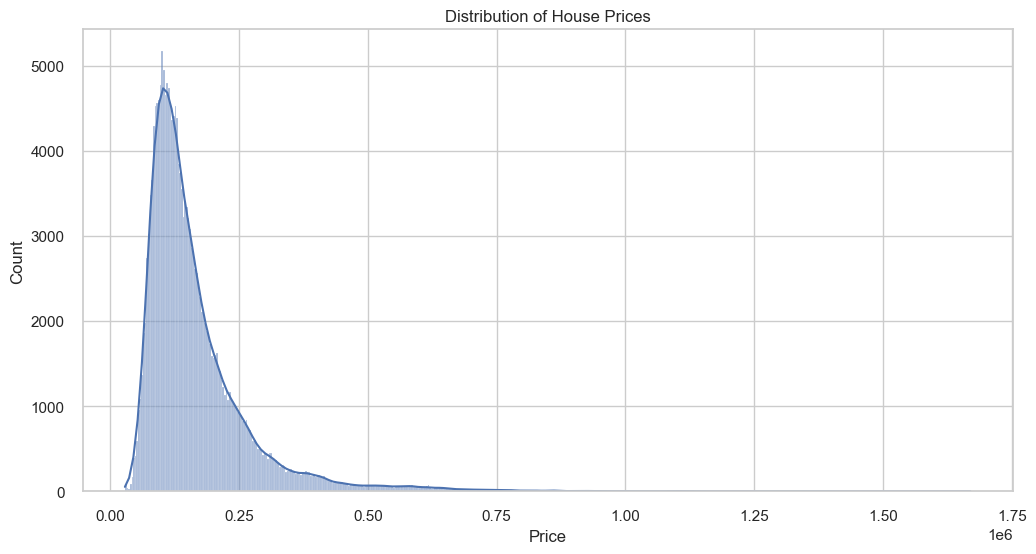

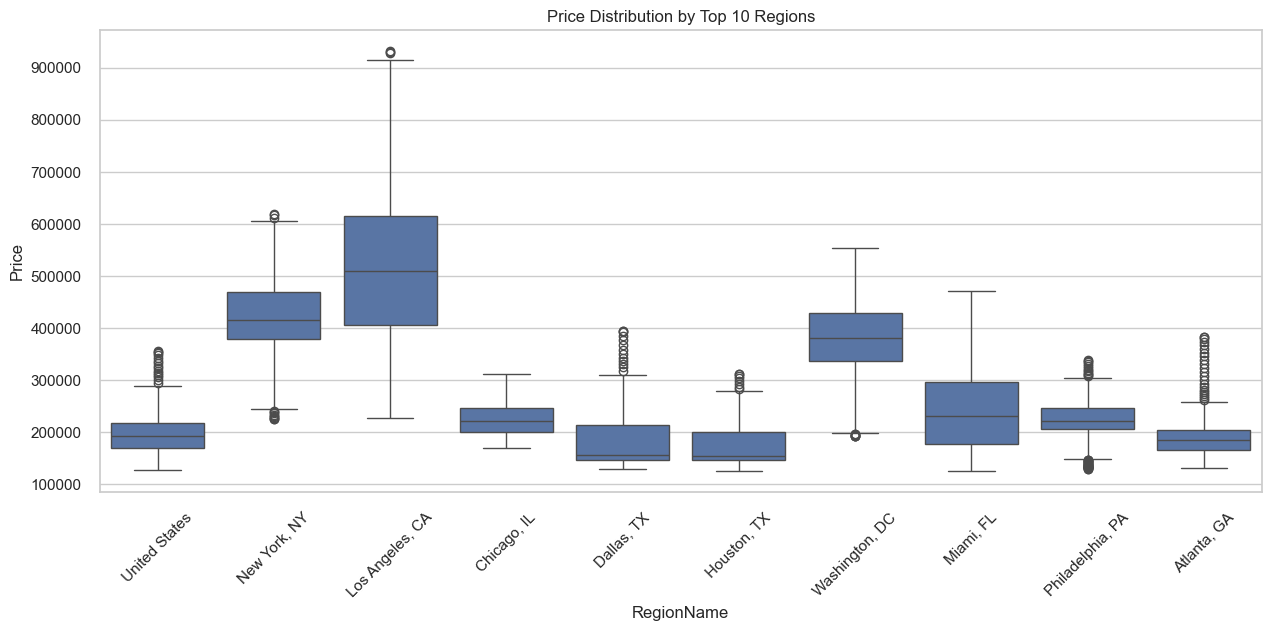

In [7]:
# 1. First, identify the columns that are truly relevant for the initial analysis
metadata_cols = ['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName']
date_cols = [col for col in df.columns if col not in metadata_cols]

# 2. Transform the dataframe to "long" format (better for temporal analysis)
df_long = df.melt(id_vars=metadata_cols, 
                  value_vars=date_cols,
                  var_name='Date',
                  value_name='Price')

# 3. Convert the date column
df_long['Date'] = pd.to_datetime(df_long['Date'])

# 4. Visualize the distribution of prices
plt.figure(figsize=(12, 6))
sns.histplot(data=df_long, x='Price', kde=True)
plt.title('Distribution of House Prices')
plt.show()

# 5. By region (Top 10 regions)
top_regions = df_long[df_long['SizeRank'] < 10]
plt.figure(figsize=(15, 6))
sns.boxplot(x='RegionName', y='Price', data=top_regions)
plt.xticks(rotation=45)
plt.title('Price Distribution by Top 10 Regions')
plt.show()

**Boxplot (Top 10 Regions)**

1. **Los Angeles, CA** stands out with a higher median price compared to other major metropolitan areas, indicating a generally more expensive housing market. Its interquartile range (IQR) is also quite large, suggesting substantial price variability within the region.

2. **New York, NY** exhibits a wide range of values, though its median price is slightly lower than Los Angeles. The presence of outliers indicates that some properties in New York are significantly more expensive (or cheaper) than the regional norm.

3. **United States (Aggregate)**, if interpreted as a national average or composite, shows a median price level that is relatively moderate. However, since it’s an aggregation, it may mask large regional disparities.

4. **Chicago, IL; Dallas, TX; Houston, TX; Philadelphia, PA; Atlanta, GA** generally have lower median prices compared to coastal markets. Their boxplots are more compact, suggesting tighter clustering of property values.

5. **Miami, FL** and **Washington, DC** occupy an intermediate position: their medians are higher than many inland cities but still below Los Angeles and New York. Miami’s boxplot in particular reveals a wide spread, indicating a notable variation in its housing market—likely reflecting differences between upscale coastal areas and inland neighborhoods.

---

**Price Distribution Histogram**

1. The distribution is **right-skewed**, with a large concentration of properties in the lower-to-middle price range (around \$200,000) and a long tail extending toward higher values.

2. The **peak** (mode) of the distribution appears at the lower end, reflecting that most properties fall into a relatively affordable bracket, while luxury and high-end properties form the tail.

3. Due to this skewness, the **mean** is pulled to the right by expensive outlier properties. Consequently, the **median** may serve as a more reliable measure of central tendency.

4. The significant tail on the upper end indicates there are properties priced well above the typical range, consistent with luxury markets in high-cost cities.

---

These visualizations highlight the considerable variation in housing prices across different metropolitan areas. Coastal cities and major financial or political centers (e.g., Los Angeles, New York, Washington, DC) tend to have higher medians and more outliers, whereas many inland regions present more clustered and affordable price ranges. The overall skewed distribution across the dataset underscores the presence of high-end properties that elevate the upper tail, reflecting diverse economic conditions and housing stock within the U.S.


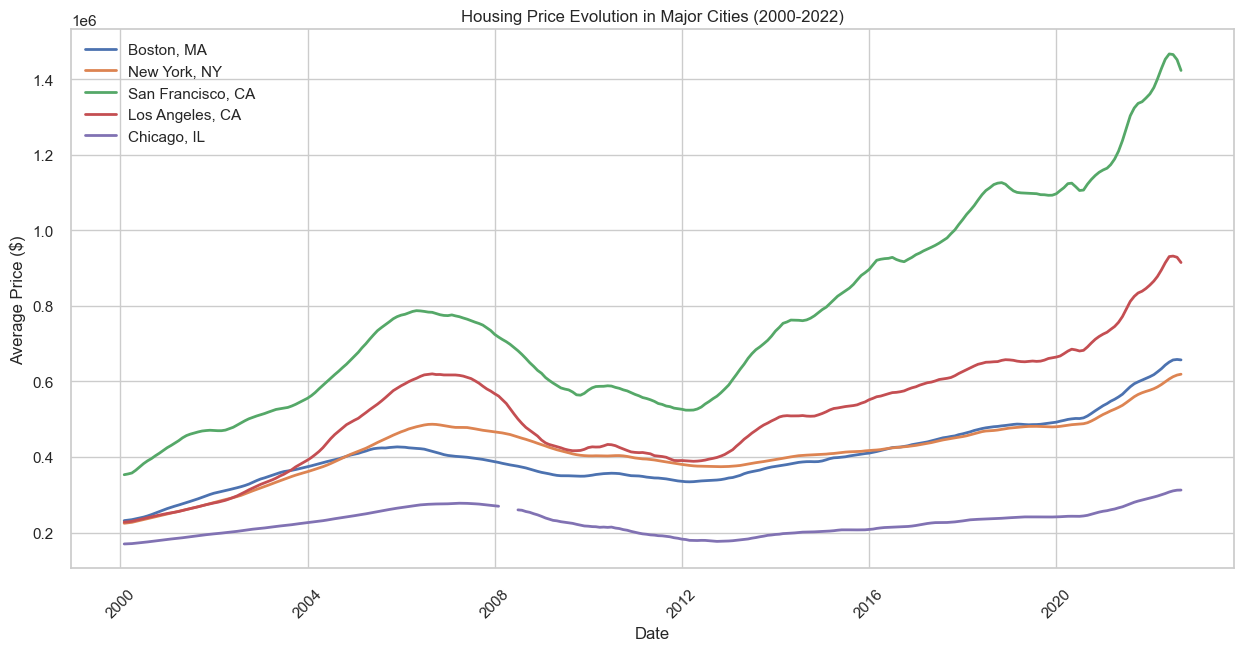

In [8]:
### **Comparing Major Cities:**

plt.figure(figsize=(15, 7))

# Select main cities for comparison
main_cities = ['Boston, MA', 'New York, NY', 'San Francisco, CA', 'Los Angeles, CA', 'Chicago, IL']
cities_data = df[df['RegionName'].isin(main_cities)]

# Create line plot for each city
for city in main_cities:
    city_data = cities_data[cities_data['RegionName'] == city].iloc[:, 5:].T
    # Converter índice para datetime
    city_data.index = pd.to_datetime(city_data.index)
    plt.plot(city_data.index, city_data.values, label=city, linewidth=2)

plt.title('Housing Price Evolution in Major Cities (2000-2022)')
plt.xlabel('Date') 
plt.ylabel('Average Price ($)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

**Housing Price Evolution in Major Cities (2000–2022)**

1. **Overall Growth Trend**  
   - All cities show a general upward trend in housing prices from 2000 to 2022, reflecting nationwide growth in real estate values over the past two decades.  

2. **Early 2000s Rise and Mid-2000s Peak**  
   - Between 2000 and approximately 2007, prices rose sharply, aligning with the broader U.S. housing boom of that era.  
   - This period of rapid growth culminated in a peak just before the financial crisis.  

3. **Impact of the 2008–2009 Recession**  
   - A noticeable dip appears around 2008–2009 across all lines, consistent with the housing market crash and subsequent economic downturn.  
   - Although all cities were affected, the magnitude and recovery pace varied by region, highlighting differences in local market resilience.  

4. **Post-Recession Recovery and Renewed Growth**  
   - Following the recession, most markets began a gradual recovery around 2010–2011, which then accelerated from 2012 onward.  
   - By the mid-2010s, prices in major coastal cities—particularly Los Angeles and San Francisco—had already surpassed their pre-crisis peaks.  

5. **City-Specific Observations**  
   - **Los Angeles, CA** and **San Francisco, CA**: Show the highest average prices by 2022, both surpassing the \$1 million mark, indicative of strong demand and limited housing supply.  
   - **Boston, MA** and **New York, NY**: Although still high relative to many U.S. regions, their growth trajectories are slightly more moderate compared to LA and San Francisco.  
   - **Chicago, IL**: Displays the lowest average prices among the five cities, suggesting a comparatively more affordable market. However, it still follows the general boom–bust–recovery pattern.  

6. **Recent Market Shifts**  
   - The chart shows continued price appreciation into the late 2010s, with some variability around 2020–2022. Factors like economic policy changes, shifts in remote work, and the COVID-19 pandemic could have influenced these fluctuations.

---

**Key Takeaways**

- **High-Cost Coastal Markets** (Los Angeles, San Francisco) have seen the most dramatic price growth and now command the highest average prices.  
- **Stable Eastern Hubs** (Boston, New York) also exhibit strong growth, though slightly less steep than their West Coast counterparts.  
- **Midwestern Markets** (Chicago) remain more affordable, yet still experience similar cyclical trends.  
- **Post-Recession Rebound** is evident across all cities, though the timing and intensity of recovery vary.  

Overall, the data underscores how national economic cycles and local housing supply-demand dynamics have driven the evolution of real estate prices in these major U.S. cities from 2000 to 2022.


In [9]:
# Initial preparation of data for temporal analysis
def prepare_time_series_data(df):
    """
    Prepares data for temporal analysis, transforming date columns
    into a format suitable for time series.
    """
    # Identifying date columns (assuming YYYY-MM-DD format)
    date_cols = [col for col in df.columns if isinstance(col, str) and 
                 len(col.split('-')) == 3 and col.split('-')[0].isdigit()]
    
    if not date_cols:
        print("No date columns found in the expected format.")
        return None
    
    # Selecting non-date columns for metadata
    metadata_cols = [col for col in df.columns if col not in date_cols]
    
    # Creating transposed DataFrame for time series
    df_time = df.melt(id_vars=metadata_cols,
                      value_vars=date_cols,
                      var_name='Date',
                      value_name='Price')
    
    # Converting date column to datetime
    df_time['Date'] = pd.to_datetime(df_time['Date'])
    
    print("=== Temporal Data Structure ===\n")
    print(f"Temporal dataset dimensions: {df_time.shape}")
    print("\nFirst rows of temporal dataset:")
    display(df_time.head())
    
    return df_time

# Preparing temporal data
df_temporal = prepare_time_series_data(df)



=== Temporal Data Structure ===

Temporal dataset dimensions: (242896, 7)

First rows of temporal dataset:


,RegionID,SizeRank,RegionName,RegionType,StateName,Date,Price
0,102001,0,United States,country,NaN,2000-01-31,127881.0
1,394913,1,"New York, NY",msa,NY,2000-01-31,224676.0
2,753899,2,"Los Angeles, CA",msa,CA,2000-01-31,227786.0
3,394463,3,"Chicago, IL",msa,IL,2000-01-31,170004.0
4,394514,4,"Dallas, TX",msa,TX,2000-01-31,129921.0


In [10]:
# Pivoting data to have one row per city with temporal values as columns
if df_temporal is not None:
    # Create a unique identifier for each date
    df_temporal['YearMonth'] = df_temporal['Date'].dt.strftime('%Y-%m')
    
    # Pivot the table to have cities as rows and dates as columns
    df = df_temporal.pivot(
        index=['RegionID', 'RegionName', 'RegionType', 'StateName'],
        columns='YearMonth',
        values='Price'
    ).reset_index()
    

    display(df.head())

YearMonth,RegionID,RegionName,RegionType,StateName,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08
0,102001,United States,country,NaN,127881.0,128227.0,128591.0,129332.0,130079.0,130824.0,131584.0,132394.0,133222.0,134055.0,134895.0,135756.0,136559.0,137298.0,138048.0,138850.0,139676.0,140486.0,141302.0,142147.0,142983.0,143824.0,144594.0,145330.0,146001.0,146702.0,147441.0,148223.0,149056.0,149933.0,150884.0,151877.0,152859.0,153846.0,154777.0,155705.0,156551.0,157414.0,158299.0,159256.0,160280.0,161300.0,162365.0,163489.0,164679.0,165867.0,166940.0,167966.0,168987.0,170159.0,171468.0,172899.0,174481.0,176166.0,177959.0,179722.0,181441.0,183076.0,184605.0,186158.0,187684.0,189286.0,190949.0,192859.0,194848.0,196920.0,198968.0,201030.0,203023.0,204875.0,206531.0,208014.0,209269.0,210482.0,211750.0,213122.0,214432.0,215531.0,216336.0,216943.0,217282.0,217526.0,217603.0,217647.0,217629.0,217648.0,217656.0,217674.0,217515.0,217162.0,216550.0,215903.0,215115.0,214295.0,213262.0,212219.0,210974.0,209626.0,208117.0,206541.0,204951.0,203272.0,201472.0,199417.0,197410.0,195479.0,193573.0,191673.0,189821.0,188371.0,187009.0,185743.0,184435.0,183239.0,182166.0,181131.0,180174.0,179429.0,179088.0,178945.0,178874.0,178766.0,178776.0,178943.0,179014.0,178802.0,178085.0,177134.0,176009.0,174914.0,173792.0,172775.0,171817.0,170955.0,170140.0,169285.0,168396.0,167550.0,166882.0,166296.0,165782.0,165239.0,164789.0,164381.0,164152.0,164042.0,164211.0,164536.0,165015.0,165469.0,165933.0,166375.0,166865.0,167448.0,168160.0,168960.0,169936.0,171027.0,172273.0,173533.0,174872.0,176237.0,177605.0,178873.0,180081.0,181241.0,182324.0,183361.0,184389.0,185447.0,186322.0,187041.0,187695.0,188366.0,188956.0,189363.0,189745.0,190235.0,190881.0,191613.0,192353.0,193176.0,194085.0,195029.0,195966.0,196775.0,197486.0,198167.0,198895.0,199657.0,200394.0,201267.0,202239.0,2

#### **Monthly Seasonality Analysis for Boston Housing Market:**

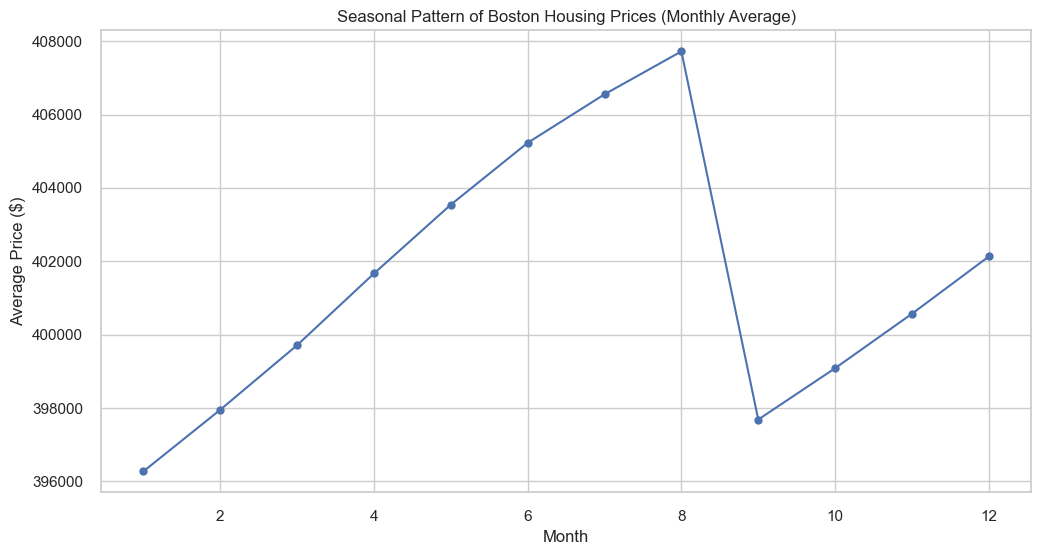

In [11]:
# Seasonality analysis for Boston
boston_monthly = boston_prices.copy()
boston_monthly.index = pd.to_datetime(boston_monthly.index)

# Create monthly decomposition
boston_monthly['Month'] = boston_monthly.index.month
monthly_mean = boston_monthly.groupby('Month')['Prices'].mean()

plt.figure(figsize=(12, 6))
monthly_mean.plot(kind='line', marker='o')
plt.title('Seasonal Pattern of Boston Housing Prices (Monthly Average)')
plt.xlabel('Month')
plt.ylabel('Average Price ($)')
plt.grid(True)
plt.show()

**Seasonal Pattern in Boston Housing Prices (Monthly Average)**

1. **Steady Climb from Winter to Late Summer**  
   - From **January (Month 1) through August (Month 8)**, there is a clear upward trajectory in average housing prices.  
   - This climb likely reflects heightened market activity in the spring and summer, when many buyers and sellers enter the market, driving prices upward.

2. **Sharp Drop in Early Fall**  
   - A noticeable drop occurs **between August and September**, suggesting a seasonal slowdown.  
   - Possible factors include reduced buyer demand post–summer season and the start of the school year, which can delay moves.

3. **Partial Recovery Toward Year-End**  
   - After the September low, prices rebound gradually through the late fall and early winter months (October to December).  
   - This recovery may not fully reach the late summer peak, but it indicates some market stabilization before the year ends.

4. **Seasonal Influences**  
   - **Weather and Lifestyle Factors**: Warmer months often see higher transaction volumes as families aim to relocate before the new school year.  
   - **Economic and Fiscal Cycles**: End-of-year bonuses, interest rate changes, and holiday spending can also impact price trends.

---

**Key Takeaways**

- **Peak Season (Spring/Summer)**: Boston’s housing market tends to be most active during spring and summer, culminating in higher average prices by August.  
- **Off-Peak Season (Fall/Winter)**: The market sees a drop in early fall, followed by a modest uptick before year-end.  
- **Strategic Timing**: Buyers looking for relatively lower prices may benefit from the early fall dip, whereas sellers often target the spring/summer months to capitalize on higher demand.

Overall, these monthly patterns underscore the importance of seasonality in the Boston housing market, with a predictable cycle of heightened activity and pricing in the warmer months, followed by a brief lull in the fall.


In [12]:
# Filtering data for train and test period:
boston_train = boston_prices['2010-01-31':'2017-12-31']
boston_test = boston_prices['2018-01-01':'2019-12-31']

#### **Deep Temporal Analysis**

Here we enhance the preparation and analysis of the temporal dimension of the data.

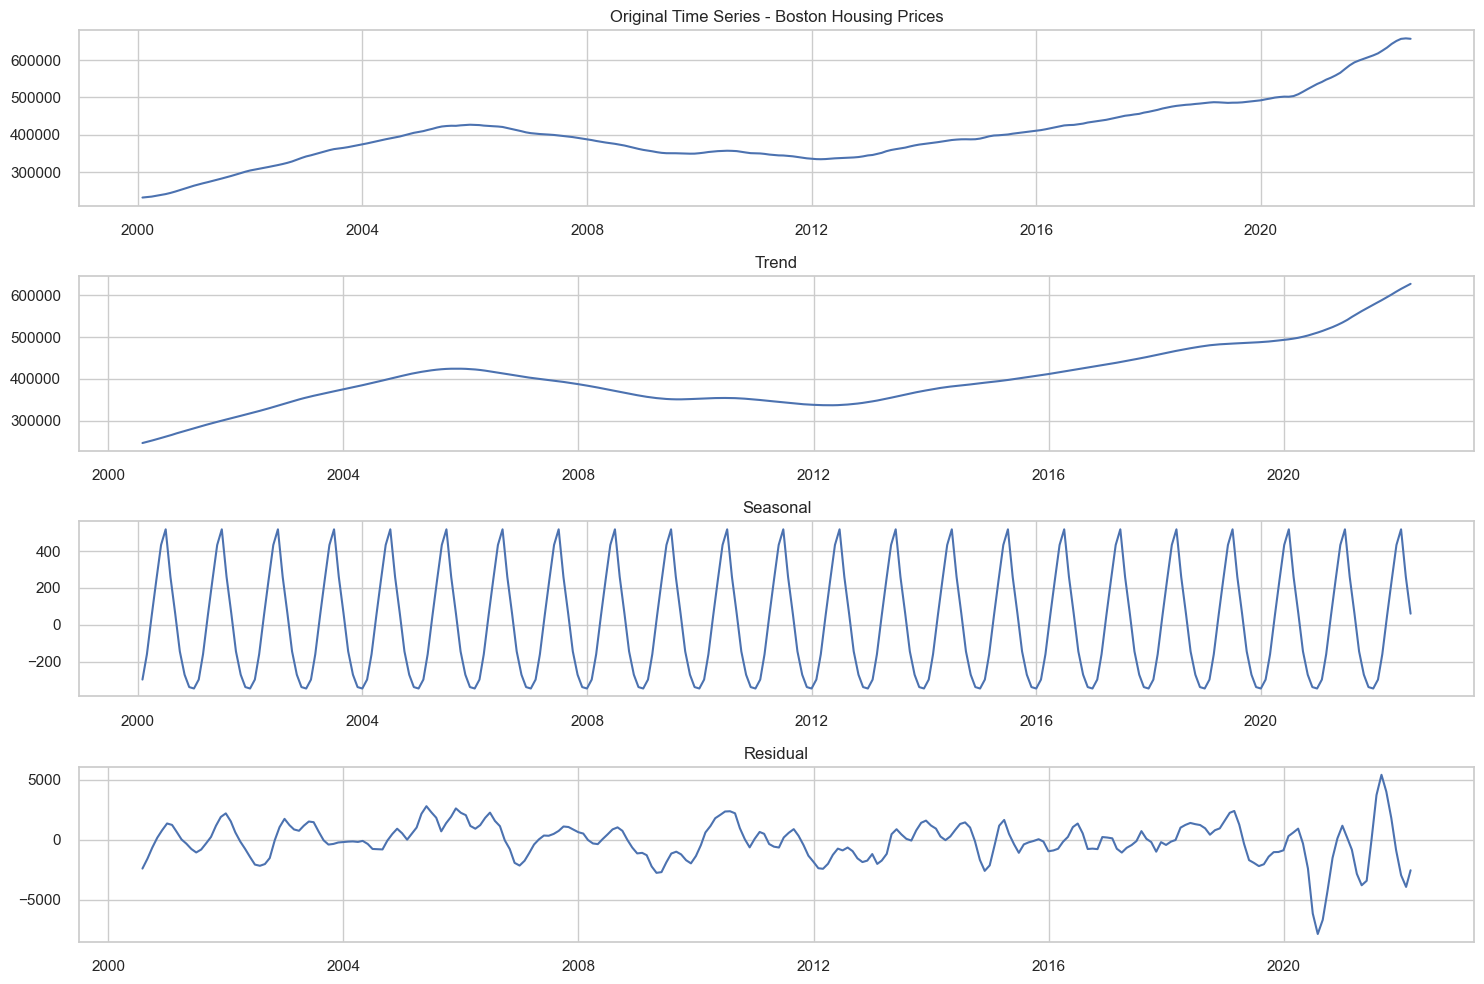

In [13]:
if df_temporal is not None:
    # Filtrando apenas para Boston
    df_boston = df_temporal[df_temporal['RegionName'] == 'Boston, MA'].copy()
    df_boston = df_boston.sort_values('Date')
    
    # Verificando se temos dados suficientes
    if not df_boston.empty:
        # Removendo valores nulos se houver
        df_boston = df_boston.dropna(subset=['Price'])
        
        # Criando série temporal adequada para decomposição
        ts = pd.Series(df_boston['Price'].values, index=pd.DatetimeIndex(df_boston['Date']))
        
        # Decomposição
        decomposition = seasonal_decompose(ts, model='additive', period=12)
        
        # Plotando com tamanho ajustado e títulos mais claros
        plt.figure(figsize=(15, 10))
        plt.subplot(411)
        plt.plot(ts)
        plt.title('Original Time Series - Boston Housing Prices')
        
        plt.subplot(412)
        plt.plot(decomposition.trend)
        plt.title('Trend')
        
        plt.subplot(413)
        plt.plot(decomposition.seasonal)
        plt.title('Seasonal')
        
        plt.subplot(414)
        plt.plot(decomposition.resid)
        plt.title('Residual')
        
        plt.tight_layout()
        plt.show()
        
        # Interactive visualization of price evolution
        fig = px.line(df_boston, x='Date', y='Price', 
                     title='Boston Housing Price Evolution Over Time')
        fig.show()
    else:
        print("No data available for Boston")

**Boston Housing Prices Time Series Decomposition – (2000–2022)**

1. **Trend Component** 
   - The series shows a steady rise from 2000 to the mid-2000s, followed by a notable downturn around 2008–2009, reflecting the broader financial crisis.  
   - After 2010, prices resume an upward trajectory, with some fluctuation in recent years but generally ending at a higher level than the early 2000s. 
   - The extracted trend line captures the long-term movement, smoothing out short-term fluctuations.  
   - It confirms a peak prior to 2008, a dip during the recession, and a gradual recovery and growth from about 2011 onward.

2. **Seasonal Component**  
   - The seasonal plot reveals a **recurrent pattern** repeating each year.  
   - These regular oscillations likely mirror real estate market seasonality, with stronger activity in certain months (often late spring and summer) and softer activity in others (typically winter).

3. **Residual Component**  
   - The residual captures the short-term irregular fluctuations that are not explained by either the trend or the seasonal pattern.  
   - While centered around zero, occasional spikes indicate periods where external factors—such as policy changes, unexpected economic events, or local market anomalies—may have impacted prices more sharply.

---

**Observations**

- **Cyclical Market Behavior**: The clear seasonal pattern underscores that housing demand in Boston tends to follow predictable annual cycles.  
- **Crisis Impact**: The 2008–2009 downturn is evident in both the original series and the smoothed trend, reflecting the nationwide housing market crash.  
- **Recovery and Growth**: Post-recession, the trend shows a consistent rise in prices, aligning with Boston’s strong economic fundamentals.  
- **Short-Term Variability**: The residual spikes remind us that unexpected events or market shifts can momentarily deviate from the underlying trend and seasonality.

Overall, the decomposition provides a clearer picture of how long-term growth, seasonal factors, and short-term fluctuations interact to shape Boston’s housing prices over the last two decades.


#### **Annual Price Changes and Seasonality Analysis for Boston:**

<Figure size 1600x400 with 0 Axes>

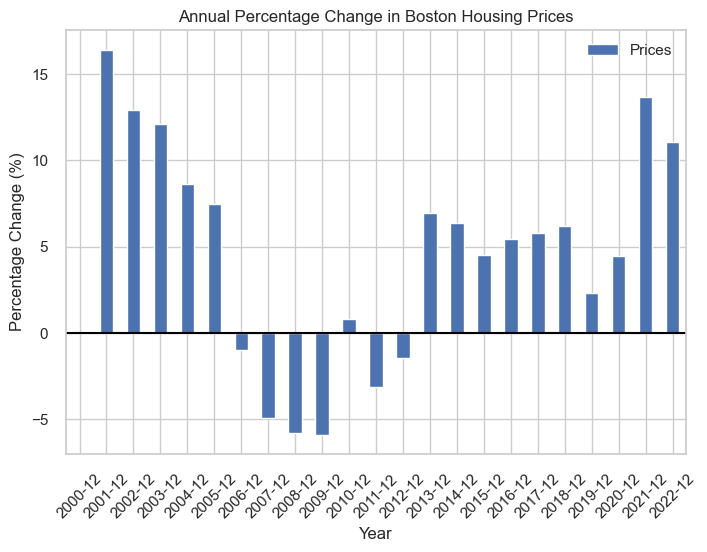

In [14]:
# Calculate year-over-year percentage change for Boston
warnings.filterwarnings('ignore')
boston_prices.index = pd.to_datetime(boston_prices.index)
boston_yearly = boston_prices.resample('Y').mean()
boston_pct_change = boston_yearly.pct_change() * 100

plt.figure(figsize=(16, 4))
boston_pct_change.plot(kind='bar')
plt.title('Annual Percentage Change in Boston Housing Prices')
plt.xlabel('Year')
plt.ylabel('Percentage Change (%)')

x_ticks = range(len(boston_yearly.index))
plt.xticks(x_ticks, [d.strftime('%Y-%m') for d in boston_yearly.index], rotation=45)
plt.axhline(y=0, color='black', linestyle='-')

plt.show()

**Analysis of Annual Percentage Change in Boston Housing Prices**

1. **Strong Early 2000s Growth**  
   - From **2000 to 2005**, Boston’s housing market experienced robust annual percentage increases, at times exceeding **10%** and even approaching **15%** in certain years.  
   - These gains align with the nationwide housing boom of the early 2000s, driven by low interest rates and abundant credit availability.

2. **Mid-2000s Downturn**  
   - Around **2006–2007**, the percentage change starts to drop, reflecting the cooling housing market and the onset of the subprime mortgage crisis.  
   - The **2008–2009** period exhibits the most pronounced declines, with annual changes dipping well into negative territory. This slump corresponds with the broader financial crisis and recession.

3. **Gradual Recovery Post-2010**  
   - After **2010**, the annual percentage change begins a slow recovery, hovering near zero or slightly positive as the market stabilizes.  
   - By **2012–2013**, the year-over-year increases return solidly into positive territory, indicating a renewed upward trajectory for Boston’s housing prices.

4. **Steady Growth into the Late 2010s**  
   - From **2014 onward**, Boston’s market consistently posts positive annual gains. Although these increases are generally more moderate than the early 2000s peak, they still represent healthy growth rates of around **5% to 10%** per year.  
   - This sustained recovery can be attributed to factors such as improved economic conditions, continued low mortgage rates, and strong demand driven by Boston’s diverse economy.

5. **Recent Market Conditions**  
   - By **2020–2022**, annual percentage changes remain positive, suggesting resilience despite broader economic uncertainties (e.g., the global pandemic).  
   - This trend underscores Boston’s enduring appeal, fueled by robust employment sectors (tech, education, healthcare) and a relatively constrained housing supply.

---

**Key Takeaways**

- **Volatile Boom-Bust Cycle**: The data reflects a classic boom-bust-recovery pattern. Boston’s market soared in the early 2000s, contracted sharply during the recession, and has since returned to a more stable growth path.  
- **Post-Crisis Recovery**: The gradual return to positive annual changes after 2012 highlights the market’s resilience and the city’s enduring economic strengths.  
- **Sustained Demand**: Continuous growth in the late 2010s and early 2020s points to ongoing demand for housing in Boston, supported by a strong job market and limited supply of new homes.

Overall, these annual percentage changes paint a picture of how broader economic forces and local dynamics shape the cyclical nature of Boston’s housing market.


# **1. Hankel-based Unstructured Model**

Upon analyzing the plot and our MSE, we observe a slight delay in the model's adaptation to changes in trend; however, it fits the data reasonably well overall.



### **ACF / PACF:**

First, we calculate and visualize the autocovariance values of the training data.

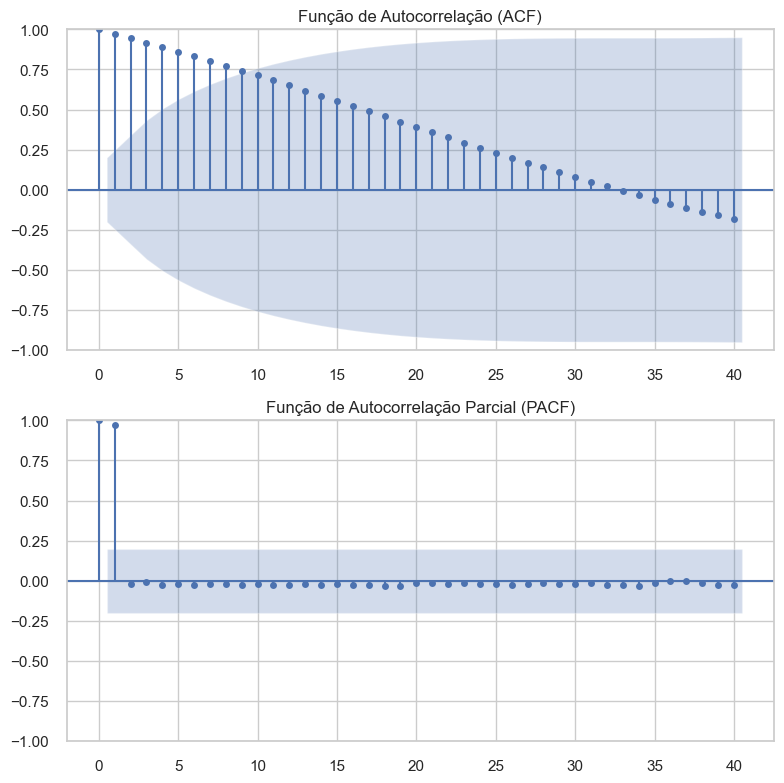

In [15]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))

# Plot ACF
plot_acf(boston_train, ax=ax1, lags=40)
ax1.set_title('Função de Autocorrelação (ACF)')

# Plot PACF 
plot_pacf(boston_train, ax=ax2, lags=40)
ax2.set_title('Função de Autocorrelação Parcial (PACF)')

plt.tight_layout()
plt.show()

**Analysing Autocorrelation (ACF) and Partial Autocorrelation (PACF):**

1. **Gradual Decay in ACF**  
   - The Autocorrelation Function (ACF) starts near 1 at lag 0 (as expected) and gradually declines over subsequent lags.  
   - This pattern suggests that the time series exhibits **persistent correlation** over multiple periods, indicating potential memory or inertia in the data.  
   - Such a slow decay is commonly associated with processes that have strong autoregressive components, where current values depend on previous observations.

2. **Single Significant Spike in PACF at Lag 1**  
   - The Partial Autocorrelation Function (PACF) shows a **strong correlation at lag 1**, with subsequent lags hovering around zero.  
   - This behavior is typical of an **AR(1) process**, implying that each data point is primarily influenced by its immediate previous value, while higher-order lags contribute minimal additional predictive power.

3. **Potential Model Implications**  
   - The combination of a **gradually decaying ACF** and a **single dominant spike in PACF at lag 1** often points to an AR(1) model as a good starting point for time series forecasting.  
   - If the time series is already stationary (e.g., mean and variance do not change over time), then no differencing may be needed before fitting an AR(1) model. However, stationarity should be confirmed via tests like **Augmented Dickey-Fuller (ADF)** or **KPSS**.


### **Hankel Matrix:**

A Hankel matrix can be formulated from the time series data.


$$
\Large H = \begin{bmatrix}
X_1 & X_2 & X_3 & \dots & X_{L-m+1} \\
X_2 & X_3 & X_4 & \dots & X_{L-m+2} \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
X_m & X_{m+1} & X_{m+2} & \dots & X_L
\end{bmatrix}
$$

Note that we use the original training data to construct this Hankel matrix.

We'll use this Hankel Matrix to construct a denoised version of it.

In [16]:
# Parameters
m = 10
L = 50
last_L_values = boston_train.iloc[-L:]

# Construct the Hankel matrix
hankel = np.zeros((m, L - m + 1))

for i in range(m):
    # Extract the values and convert to 1D array
    values = last_L_values.iloc[i : i + (L - m + 1)].values.flatten()
    hankel[i] = values

hankel.shape


(10, 41)

### **SVD:**

Here, we perform singular-value thresholding on the Hankel matrix.

In [17]:
# Calculating the SVD:
U , s , Vh = np.linalg.svd(hankel, full_matrices=False)

In [18]:
# Checking dimensions:
print(U.shape, s.shape, Vh.shape)

# Displaying matrices:
print('U =\n',U,'\n')
print('V_trans =\n',Vh,'\n')
print('s =\n',s,'\n')

(10, 10) (10,) (10, 41)
U =
 [[ 0.31017914  0.37778628  0.37055541 -0.4582331   0.46551432 -0.33385381
  -0.15032124  0.21637647  0.0832846  -0.09624978]
 [ 0.31147831  0.39700893  0.29545853 -0.09869751 -0.16351226  0.39713704
   0.23040391 -0.50229565 -0.32327444  0.23233789]
 [ 0.31279689  0.3605692   0.06128185  0.26740719 -0.41696121  0.19419561
   0.09368327  0.36867705  0.56916549 -0.12910704]
 [ 0.31413257  0.25748294 -0.23924047  0.39545791 -0.14426378 -0.26648637
  -0.40594375  0.05248838 -0.53858301 -0.26824664]
 [ 0.3154964   0.09744683 -0.45575781  0.20161601  0.25808029 -0.32015891
   0.25261527 -0.08041249  0.16700339  0.61263693]
 [ 0.31685701 -0.07958639 -0.46544107 -0.16708825  0.28453616  0.28424987
  -0.01437992 -0.38526867  0.24905379 -0.52563146]
 [ 0.31821808 -0.23833917 -0.26386943 -0.399075   -0.1099307   0.27417187
   0.23830694  0.56938584 -0.37270775  0.0767287 ]
 [ 0.31957101 -0.34446443  0.04141496 -0.30397071 -0.4089135  -0.10390904
  -0.57851048 -0.20471

In [19]:
# Creating a diagonal matrix with the singular values:
s_mat = np.diag(s)

#Estimate rank of Page matrix
r=0;
for i in range(L):
 if (sum(np.square(s[:i]))/sum(np.square(s)))>=0.99:
    r=i;
    break;
print('\n The 90% singular value is concentrated in the first r dimensions, r=',r)

# Constructing the truncated singular matrix:
strunmat = np.zeros((int(m), int(m)))
strunmat[:r, :r] = np.diag(s[0:r])
print('Truncated S matrix:\n', strunmat, '\n')



 The 90% singular value is concentrated in the first r dimensions, r= 1
Truncated S matrix:
 [[8364075.45019703       0.               0.               0.
        0.               0.               0.               0.
        0.               0.        ]
 [      0.               0.               0.               0.
        0.               0.               0.               0.
        0.               0.        ]
 [      0.               0.               0.               0.
        0.               0.               0.               0.
        0.               0.        ]
 [      0.               0.               0.               0.
        0.               0.               0.               0.
        0.               0.        ]
 [      0.               0.               0.               0.
        0.               0.               0.               0.
        0.               0.        ]
 [      0.               0.               0.               0.
        0.               0.            

In [20]:
# Cronstructing denoised matrix:
hankel_hat = U @ strunmat @ Vh

### **OLS Regression:**

Now we conduct an ordinary least squares (OLS) approach to fit a regression model. The OLS regression will derive a parametric model to capture the non-stationary trend, and note that we don't consider constant terms. 

We then use this model to generate the predictions for some training and test months, and these estimations could guide us to the residual series and the non-stationary component for predictions on test months.

In [21]:
# Extracting last row of hankel:
y = hankel[-1,:].reshape(-1, 1)

# Extracting all rows except the last one:
x = hankel_hat[:-1,:]

# Checking dimensions:
x.shape, y.shape

((9, 41), (41, 1))

In [22]:
# Fitting OLS model without a constant term:
model = sm.OLS(y, x.T)

# Fitting the model:
results = model.fit()

# Extracting coefficients:
betas = results.params.reshape(-1,1)

# Displaying model summary:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          2.897e+06
Date:                Mon, 17 Feb 2025   Prob (F-statistic):                    7.95e-99
Time:                        20:17:32   Log-Likelihood:                         -359.75
No. Observations:                  41   AIC:                                      721.5
Df Residuals:                      40   BIC:                                      723.2
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1116   6.56e-05   1702.059      0.000       0.111       0.112
x2             0.1121   6.58e-05   1702.059      0.000       0.112       0.112
x3             0.1125   6.61e-05   1702.059      0.000       0.112       0.113
x4             0.1130   6.64e-05   1702.059      0.000       0.113       0.113
x5             0.1135   6.67e-05   1702.059      0.000       0.113       0.114
x6             0.1140    6.7e-05   1702.059      0.000       0.114       0.114
x7             0.1145   6.73e-05   1702.059      0.000       0.114       0.115
x8             0.1150   6.75e-05   1702.059      0.000       0.115       0.115
x9             0.1155   6.78e-05   1702.059      0.000       0.115       0.116
==============================================================================
Omnibus:                        6.513   Durbin-Watson:                   0.229
Prob(Omnibus):                  0.039   Jarque-Bera (JB):                5.190
Skew:                          -0.787   Prob(JB):                       0.0746
Kurtosis:                       3.750   Cond. No.                     9.73e+16
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The smallest eigenvalue is 6.62e-21. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [23]:
# Extracting the last 9 values:
x_est = boston_train.tail(9)

# Reshape to have a column matrix:
x_est = x_est.values.reshape(-1,1)

x_est, betas


(array([[442791.],
        [445409.],
        [448045.],
        [450885.],
        [452393.],
        [454372.],
        [455955.],
        [459183.],
        [461409.]]),
 array([[0.11158297],
        [0.11205033],
        [0.11252467],
        [0.11300517],
        [0.11349578],
        [0.11398525],
        [0.11447487],
        [0.11496157],
        [0.11545886]]))

In [24]:
# Calculating the prediction:
nonstat_predict = betas.T @ x_est.reshape(-1,1)

nonstat_predict/1000



array([[462.07855839]])

# **2. Autoregressive Model**

### **Short-term Forecast:**


<img src="./images/svd_4.png" alt="Descrição da Imagem" width="700"/>

#### **Plotting Residuals and checking Stationarity:**

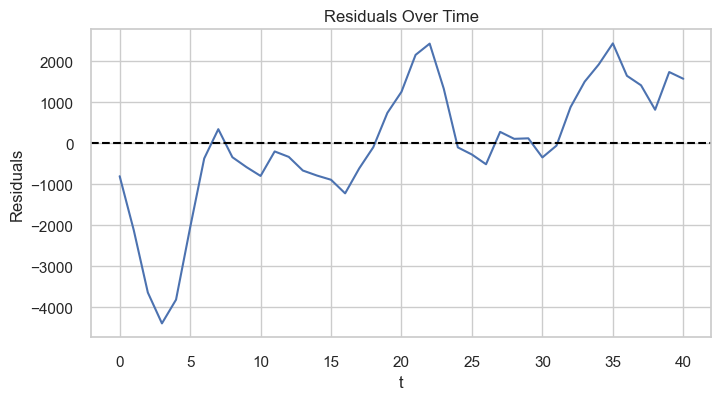

In [25]:
residuals = results.resid

plt.figure(figsize=(8,4))
sns.lineplot(data=residuals)
plt.axhline(y=0, color='black', linestyle='--') 
plt.title('Residuals Over Time')
plt.xlabel('t')
plt.ylabel('Residuals')
plt.show()



In [26]:
# Here we check stationarity running the Adfuller Test
adf_test = adfuller(residuals, regression='n')

adf_test[1] # p_value


0.01985489874228016

As we found a p-value of approximately 2%, we can proceed to fit an AR model to the residuals.

### **Fitting AR to the residuals:**

In this step, we will develop an autoregressive (AR) model to capture the residual series. In this project I'll stick to an AR(1) model, but feel free to experiment with different orders.

In [27]:
model = ARIMA(residuals, order=(1,0,0))

results = model.fit()

results.summary()   


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   41
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -329.409
Date:                Mon, 17 Feb 2025   AIC                            664.819
Time:                        20:17:32   BIC                            669.960
Sample:                             0   HQIC                           666.691
                                 - 41                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -57.0221    946.956     -0.060      0.952   -1913.021    1798.977
ar.L1          0.8766      0.062     14.172      0.000       0.755       0.998
sigma2      5.473e+05   1.36e+05      4.021      0.000    2.81e+05    8.14e+05
===================================================================================
Ljung-Box (L1) (Q):                  11.90   Jarque-Bera (JB):                 0.77
Prob(Q):                              0.00   Prob(JB):                         0.68
Heteroskedasticity (H):               0.39   Skew:                            -0.31
Prob(H) (two-sided):                  0.09   Kurtosis:                         2.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### **Information Criteria**
To select which model to use, comparing mean squared error is a good starting place, but it's better to have some other metrics. 

Information criteria are one such metric, that tell you about the balance between gaining more accuracy from including more terms and potentially overfitting the model.
 
Models are selected to minimize AIC/BIC. 

The main idea is to find a balance between model fit and complexity. 

**AIC** (Akaike Information Criteria): $-2 * \text{log-likelihood} + 2k$ 

**BIC** (Bayesian Information Criteria): $-2 * \text{log-likelihood} + k \log(n)$ 

where $k$ is the model complexity (degrees of freedom used up) and $n$ is the number of elements. 

A good practice is to select a model that minimizes both of these criteria; when they disagree, turn to another approach like out-of-sample validation. 

The prediction for one typical month is the addition of the results from the Hankel-based regression model and the above AR(1) model. 

The final prediction for the test period is concatenation of all these monthly estimates.

In [28]:
# Making the point forecast for the next period
stat_predict = results.predict(start=len(residuals), end=len(residuals))

# Calculating the forecast for the next period:
total_predict = nonstat_predict + stat_predict[0]
print(f"Non-stationary component: {nonstat_predict[0][0]:.2f}")
print(f"Stationary component: {stat_predict[0]:.2f}")
print(f"Total prediction for the next period: {total_predict[0][0]:.2f}")



Non-stationary component: 462078.56
Stationary component: 1372.46
Total prediction for the next period: 463451.01


### **Rolling Predictions:**

<img src="./images/svd_5.png" alt="Descrição da Imagem" width="700"/>

In [29]:
# Function for one-month ahead prediction:
def make_single_prediction(train_data, L, m, r=2):
    # Get the last L values:
    last_L_values = train_data.iloc[-L:]
    
    # Construct Hankel matrix:
    hankel = np.zeros((m, L - m + 1))
    for i in range(m):
        values = last_L_values.iloc[i : i + (L - m + 1)].values.flatten()
        hankel[i] = values
    
    # SVD:
    U, s, Vh = np.linalg.svd(hankel, full_matrices=False)
    
    # Truncated singular matrix:
    strunmat = np.zeros((int(m), int(m)))
    strunmat[:r,:r] = np.diag(s[0:r])
    
    # Reconstruct Hankel matrix:
    hankel_hat = U @ strunmat @ Vh
    
    # OLS Regression:
    y = hankel[-1,:].reshape(-1, 1)
    x = hankel_hat[:-1,:]
    
    # Fit OLS model:
    model = sm.OLS(y, x.T)
    results = model.fit()
    betas = results.params.reshape(-1,1)
    
    # Non-stationary component prediction (Hankel>SVD>Reconstruct>OLS):
    x_previous = train_data.tail(m-1).values.reshape(-1,1)  # Last m-1 values
    nonstat_predict = betas.T @ x_previous.reshape(-1,1) # Dot product
    
    # Stationary component prediction (AR(3) on residuals):
    residuals = results.resid
    arima_model = ARIMA(residuals, order=(3,0,0), trend='n')
    arima_results = arima_model.fit()
    stat_predict = arima_results.predict(start=len(residuals), end=len(residuals))
    
    # Total prediction:
    total_predict = nonstat_predict + stat_predict[0]
    
    return total_predict[0][0]

# Perform rolling predictions:
def make_rolling_predictions(train_data, test_data, n_steps, L, m):
    predictions = []
    current_train = train_data.copy()
    
    for _ in range(n_steps):
        # Make prediction:
        pred = make_single_prediction(current_train, L, m)
        predictions.append(pred)
        
        # Add prediction to training set:
        new_index = pd.date_range(start=current_train.index[-1], periods=2, freq='M')[1]
        current_train.loc[new_index] = test_data.iloc[_]['Prices']
    
    #print(current_train.tail(30))  ### uncomment to check updates

    return predictions


In [30]:
# Generating rolling predictions:
n_predictions = len(boston_test)
rolling_forecast = make_rolling_predictions(boston_train, boston_test, n_predictions, 50, 10)

# Create DataFrame with predictions:
forecast_dates = pd.date_range(start=boston_train.index[-1], periods=25, freq='M')[1:]
forecast_df = pd.DataFrame(rolling_forecast, index=forecast_dates, columns=['Prices'])

# MSE
mse = mean_squared_error(boston_test['Prices'], forecast_df['Prices'])
print(f'Mean Squared Error (MSE): {mse/1e3}')



Mean Squared Error (MSE): 1262.3564810388016


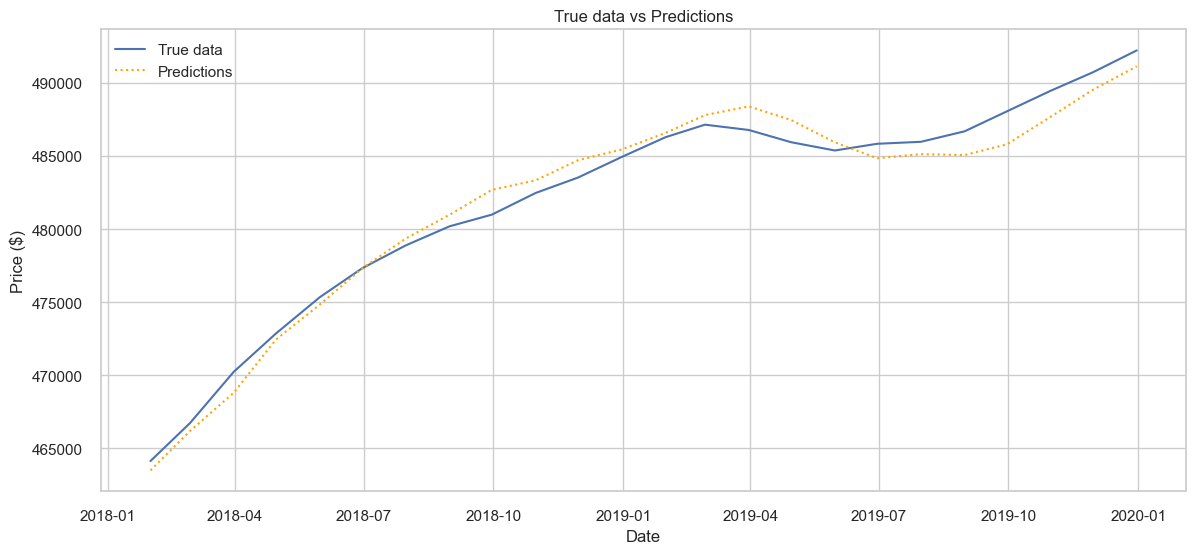

In [31]:
# Creating the plot
plt.figure(figsize=(14, 6))

# Converting indices to datetime with timezone
boston_test.index = pd.to_datetime(boston_test.index, utc=True)
forecast_df.index = pd.to_datetime(forecast_df.index, utc=True)

# Plotting the time series only for the test period
plt.plot(boston_test.index, boston_test['Prices'], 
         label='True data')

# Plotting the predictions only for the test period
plt.plot(forecast_df.index, forecast_df['Prices'], 
         label='Predictions',
         linestyle=':',
         color='orange')

# Customizing the plot
plt.title('True data vs Predictions')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)


plt.show()


**Results Analysis**

---

1. **Overall Trend Alignment**  
   - The predicted values (dotted line) closely follow the upward trajectory of the actual data (solid line), indicating that the model captures the general growth pattern over this two-year period.

2. **Minor Deviations**  
   - While the model generally remains close to the true data, small gaps appear intermittently—particularly around mid-2018 and again near the transition from 2019 to 2020.  
   - These discrepancies suggest that short-term fluctuations or local market variations may not be fully accounted for in the model.

3. **Stable Performance Toward the End of the Series**  
   - By late 2019, the predictions and actual values converge, illustrating a reduced error margin as the model benefits from more recent data.  
   - This consistency indicates the model’s ability to adapt to the ongoing trend once sufficient recent observations are available.



# **Conclusion**

- **Good Overall Fit**: The forecast tracks the long-term upward trend effectively, making it useful for strategic planning or scenario analysis.  
- **Small, Manageable Error**: Minor short-term deviations highlight areas where deeper feature engineering or supplementary data could enhance performance.  

Overall, the model delivers a reliable picture of housing price movements from 2018 to 2020, capturing the market’s general direction and offering a strong foundation for further predictive improvements.